## 20.3.1. Smooth functions

In [31]:
from ngsolve import *
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 

def ComputeError (func, order, maxh=0.3, reflevels=0):
    mesh = Mesh(unit_square.GenerateMesh(maxh=maxh))
    for l in range(reflevels):
        mesh.Refine()
    fes = H1(mesh, order=order)
    gfu = GridFunction(fes)
    gfu.Set (func)

    err = sqrt(Integrate( (func-gfu)**2, mesh, order=2*order+4))
    return fes.ndof, err

In [2]:
ComputeError(x*x, order=1, maxh=0.5, reflevels=4)


(833, 0.00017516866346059315)

In [3]:
errors = []
hs = []
func = sin(pi*x)
for l in range(6):
    ndof, err = ComputeError (func, order=2, maxh=1, reflevels=l)
    errors.append(err)
    hs.append(1/2**l)

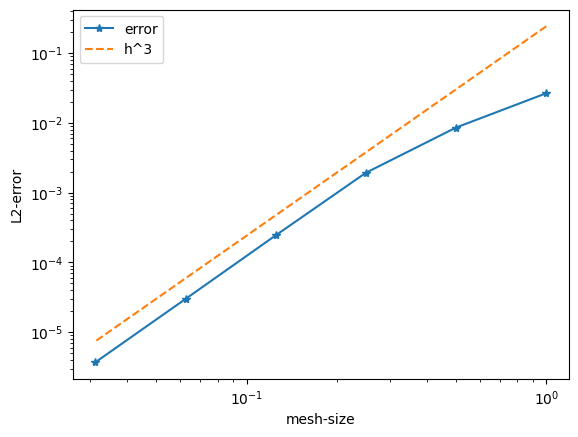

In [5]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mesh-size')
plt.ylabel('L2-error')
plt.plot (hs, errors, '-*', label="error")
plt.plot ( [hs[0], hs[-1]], [2*errors[-1]*(hs[0]/hs[-1])**3,2*errors[-1]], '--', label="h^3")
plt.legend();

## Study convergence depending on polynomial order.

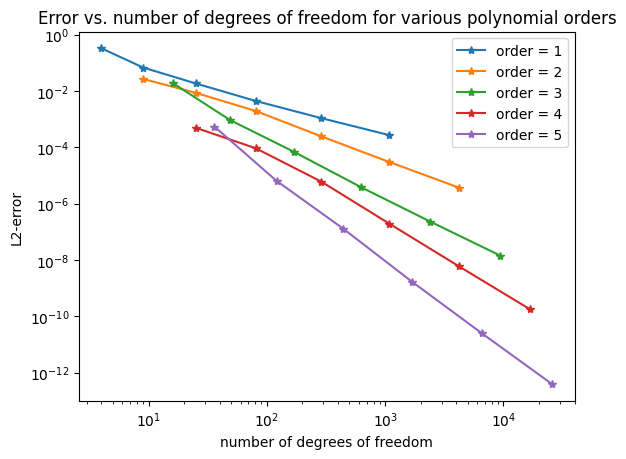

In [19]:
orders = [1, 2, 3, 4, 5]
maxh = 1
reflevels = 5

dofs_dict = {}
errs_dict = {}

for order in orders:
    dofs_list = []
    errs_list = []
    for l in range(reflevels+1):
        ndof, err = ComputeError(func, order=order, maxh=maxh, reflevels=l)
        dofs_list.append(ndof)
        errs_list.append(err)
    dofs_dict[order] = dofs_list
    errs_dict[order] = errs_list


plt.figure()
for order in orders:
    plt.plot(dofs_dict[order], errs_dict[order], '-*', label=f"order = {order}")

plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of degrees of freedom')
plt.ylabel('L2-error')
plt.legend()
plt.title('Error vs. number of degrees of freedom for various polynomial orders')
plt.show()

In [14]:
func = sin(10*x*y)
print ("func=\n", func)
gradfunc = CF( (func.Diff(x), func.Diff(y))) # make vectorial coefficient-function of partial derivatives
print ("gradient=\n", gradfunc)

func=
 coef unary operation 'sin', real
  coef binary operation '*', real
    coef scale 10, real
      coef coordinate x, real
    coef coordinate y, real

gradient=
 coef unary operation ' ', real, dim=2
  coef VectorialCoefficientFunction, real, dim=2
    coef binary operation '*', real
      coef unary operation 'cos', real
        coef binary operation '*', real
          coef scale 10, real
            coef coordinate x, real
          coef coordinate y, real
      coef binary operation '*', real
        coef coordinate y, real
        coef scale 10, real
          coef 1, real
    coef binary operation '*', real
      coef unary operation 'cos', real
        coef binary operation '*', real
          coef scale 10, real
            coef coordinate x, real
          coef coordinate y, real
      coef binary operation '*', real
        coef scale 10, real
          coef coordinate x, real
        coef 1, real



In [25]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
order = 2
fes = H1(mesh, order=order)
gfu = GridFunction(fes)
gfu.Set(func) 
grad_err = sqrt(
    Integrate(
        (gradfunc - grad(gfu)) * (gradfunc - grad(gfu)),
        mesh,
        order=2*order+4
    )
)
grad_err

0.0281903586991942

### 20.3.2.3. Functions with singularities

In [26]:
from netgen.occ import *
square = Rectangle(1,1).Face()
square.vertices.Min(X+Y).hpref = 1
mesh = Mesh(OCCGeometry(square, dim=2).GenerateMesh(maxh=0.3))
mesh.RefineHP(4, factor=0.25)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

In [37]:
alpha = 0.5 #random exponent
u_sing = (x**2 + y**2)**(alpha/2)
fes = H1(mesh, order=3) 
gfu = GridFunction(fes)
gfu.Set(u_sing)
error_L2 = sqrt(Integrate((u_sing - gfu)**2, mesh, order=6)) 
print(error_L2)
grad_sing = CF((u_sing.Diff(x), u_sing.Diff(y)))
error_H1semi = sqrt(Integrate((grad_sing - grad(gfu))*(grad_sing - grad(gfu)), 
                              mesh, order=6))
print(error_H1semi)

0.0005454752868266417
0.03360910909389739


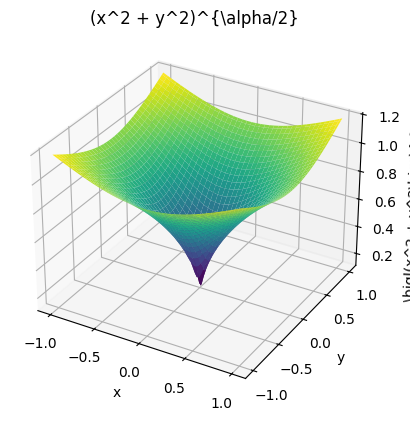

In [38]:
n_points = 80
domain_size = 1.0  # plot in [-1,1] x [-1,1]

x_vals = np.linspace(-domain_size, domain_size, n_points)
y_vals = np.linspace(-domain_size, domain_size, n_points)
X, Y = np.meshgrid(x_vals, y_vals)

R = np.sqrt(X*X + Y*Y)
eps = 1e-15
R[R < eps] = eps

Z = R**alpha

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, linewidth=0, cmap='viridis')

ax.set_title(r"(x^2 + y^2)^{\alpha/2}")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"\bigl(x^2 + y^2\bigr)^{\alpha/2}")

plt.show()

## Discontinuous functions

In [39]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.05))
func = IfPos( (x-0.5)**2 + (y-0.5)**2 - 0.3**2, 0, 1)
Draw (func, mesh, order=10);   # use 10^2 points per element for plotting

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

In [40]:
square = Rectangle(1,1).Face()
circ = Circle((0.5, 0.5), 0.3).Face()
outer = square-circ
circ.faces.name="inner"
outer.faces.name="outer"
shape = Glue([outer,circ])
Draw (shape)
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=0.05)).Curve(1)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

“resolving the discontinuity by the geometry” means you turn the interface into a genuine boundary between two subdomains so that each subdomain can be meshed separately. Then a conforming $H^1$ -based solution need not forcibly be continuous across that interface. We should switch to a discontinuous finite element space (e.g., an $𝐿^2$ - or DG space) if our function or PDE solution is genuinely discontinuous (or only piecewise smooth with jumps) ~and~ does not have the continuity requirements that come with an $𝐻^1$-conforming space.